<a href="https://colab.research.google.com/github/fxop0218/APS-Flask/blob/main/tps_nov_2022_en_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPS Nov-2022

## Dataset Description
In this competition, you are given a folder of submissions that contain predictions for a binary classification task. The ground truth for these rows are provided in the file train_labels.csv. Each file name in the submissions folder corresponds to the logloss score of the the first half of the prediction rows against the ground truth labels in that file. This is effectively the "training" set.

Your task is to use blend (ensemble) the various submission files to produce better model predictions. You can tell if the blend produces better results because you have the ground truth labels for the first half of the rows. In other words, you can blend two files together, check the score on the first half of the rows, and the score improves, you can submit the results from the rest of the rows to the leaderboard.

## Import libs

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets list
!kaggle datasets download -d varsharainer/dna-sequencing-classifier

ls: cannot access 'kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
/content
ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                       Diabetes Dataset                                      9KB  2022-10-06 08:55:25          18227        517  1.0              
akshaydattatraykhare/data-for-admission-in-the-university   Data for Admission in the University                  4KB  2022-10-27 11:05:45           5195        123  1.0              
thedevastator/jobs-dataset-from-glassdoor                   Salary Prediction                                     3MB  2022-11-16 13:52:31 

In [3]:
cd sample_data/

/content/sample_data


In [4]:
!ls

anscombe.json		      README.md
california_housing_test.csv   sample_submission.csv
california_housing_train.csv  submission_files
kaggle.json		      tabular-playground-series-nov-2022
mnist_test.csv		      train_labels.csv
mnist_train_small.csv


In [5]:
!kaggle competitions download -c tabular-playground-series-nov-2022

100% 1.06G/1.06G [00:06<00:00, 164MB/s]
100% 1.06G/1.06G [00:06<00:00, 185MB/s]


In [6]:
!mkdir tabular-playground-series-nov-2022

mkdir: cannot create directory ‘tabular-playground-series-nov-2022’: File exists


In [7]:
!ls

anscombe.json		      README.md
california_housing_test.csv   sample_submission.csv
california_housing_train.csv  submission_files
kaggle.json		      tabular-playground-series-nov-2022
mnist_test.csv		      tabular-playground-series-nov-2022.zip
mnist_train_small.csv	      train_labels.csv


In [8]:
!mv tabular-playground-series-nov-2022.zip ./tabular-playground-series-nov-2022

In [9]:
cd tabular-playground-series-nov-2022/

/content/sample_data/tabular-playground-series-nov-2022


In [10]:
!unzip tabular-playground-series-nov-2022.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: submission_files/0.6223807245.csv  
  inflating: submission_files/0.6225426578.csv  
  inflating: submission_files/0.6247722291.csv  
  inflating: submission_files/0.6253455681.csv  
  inflating: submission_files/0.6254850917.csv  
  inflating: submission_files/0.6255093621.csv  
  inflating: submission_files/0.6260141578.csv  
  inflating: submission_files/0.6263493693.csv  
  inflating: submission_files/0.6272779211.csv  
  inflating: submission_files/0.6272932068.csv  
  inflating: submission_files/0.6278191266.csv  
  inflating: submission_files/0.6286579774.csv  
  inflating: submission_files/0.6288297558.csv  
  inflating: submission_files/0.6288608516.csv  
  inflating: submission_files/0.6294457895.csv  
  inflating: submission_files/0.6297384065.csv  
  inflating: submission_files/0.6301504673.csv  
  inflating: submission_files/0.6312756578.csv  
  inflating: submission_files/0.6321136145.csv  
  inflat

In [11]:
pip install tensorflow -q

In [12]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.layers import Conv1D, AvgPool1D, Dropout, Flatten, Dense, InputLayer

## Constants 👨‍🎓

In [13]:
DIR = "../tabular-playground-series-nov-2022"
SUBMISSION_DIR_NAME = "submission_files"
SAMPLE_SUBMISSION_FILENAME = "sample_submission.csv"
TRAIN_LABELS_FILENAME = "train_labels.csv"

SUBMISSION_FILES = os.path.join(DIR, SUBMISSION_DIR_NAME)
SAMPLE_SUBMISSION = os.path.join(DIR, SAMPLE_SUBMISSION_FILENAME)
TRAIN_LABELS = os.path.join(DIR, TRAIN_LABELS_FILENAME)

ACTIVATION_FUNCTION = "relu"
OUTPUT_FUNCTION = "sigmoid"

Functions 🧮

In [14]:
def reshape_train(df):
    df = df.values
    df = df.reshape(len(df), df.shape[1],1)
    return df

## Data processing 🐱‍💻

**🟦EN** Import all the dataframes and the list of filen into submission_files

**🟥ES** Importamos todos los dataframes y la lista de archivos dentro de submission_files

In [15]:
d = pd.read_csv(SAMPLE_SUBMISSION)
labels = pd.read_csv(TRAIN_LABELS, index_col="id")
submission_files = sorted(os.listdir(SUBMISSION_FILES))

**🟦EN** Read the first CSV of submission_file

**🟥ES** Leer el primer archvivo de la carpata submission file

In [16]:
sub_fil = pd.read_csv(os.path.join(SUBMISSION_FILES, submission_files[0]))

In [17]:
sub_fil.head()

,id,pred
0,0,0.709336
1,1,0.452988
2,2,0.675462
3,3,0.481046
4,4,0.957339


**🟦EN** Put into variable all the rows in the CSV file

**🟥ES** Poner dentro de la varable todos los CSV file

In [18]:
num_labels = labels.shape[0]

**🟦EN** Create a array of zeros

**🟥ES** Creamos una array de ceros

In [19]:
X_train = np.zeros((sub_fil.shape[0], len(submission_files)))
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**🟦EN** Create a dataframa with all the values in the submission files CSVs

**🟥ES** Creamos un dataframe con todos los valores del submission file

In [20]:
for i, file_name in enumerate(submission_files):
    sub_file = pd.read_csv(os.path.join(SUBMISSION_FILES, file_name))
    X_train[:,i] = sub_file.pred.values

X_train_df = pd.DataFrame(X_train, columns=submission_files)
X_train_df.head()

,0.6222863195.csv,0.6223807245.csv,0.6225426578.csv,0.6247722291.csv,0.6253455681.csv,0.6254850917.csv,0.6255093621.csv,0.6260141578.csv,0.6263493693.csv,0.6272779211.csv,...,0.7519100517.csv,0.7519556278.csv,0.7520219713.csv,0.7521219579.csv,0.7522329272.csv,0.7523602310.csv,0.7526089604.csv,0.7526999358.csv,0.7551167673.csv,0.7575039918.csv
0,0.709336,0.799007,0.851891,0.537158,0.623930,0.705970,0.503437,0.633185,0.641550,0.666604,...,0.769207,0.750250,0.663370,0.739333,0.822384,0.749498,0.729800,0.867847,0.745888,0.787
1,0.452988,0.364453,0.567582,0.354468,0.513818,0.584119,0.454809,0.238501,0.472171,0.522314,...,0.640052,0.794052,0.721298,0.804369,0.620626,0.733606,0.816942,0.814229,0.598331,0.547
2,0.675462,0.842260,0.800013,0.525229,0.692071,0.715418,0.651008,0.609124,0.691198,0.609994,...,0.812841,0.779859,0.865657,0.828493,0.763010,0.802883,0.806891,0.896058,0.855776,0.667
3,0.481046,0.577118,0.683032,0.541356,0.630088,0.664514,0.413373,0.508210,0.526140,0.584565,...,0.824703,0.799698,0.800130,0.716604,0.603779,0.708499,0.844837,0.853057,0.850657,0.622
4,0.957339,0.910337,0.917322,0.874487,0.787595,0.854273,0.843846,0.876749,0.821128,0.913054,...,0.934803,0.900150,0.960911,0.906037,0.961240,0.935608,0.889757,0.978505,0.953681,0.934


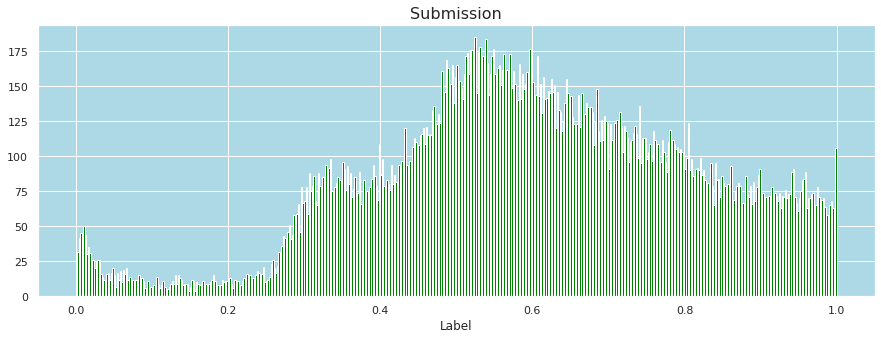

Mean Value: 0.600081020475


In [21]:
sns.set()
plt.figure(figsize=(15, 5))
plt.gca().set_facecolor('lightblue')
plt.hist(sub_fil['pred'], bins=500, color='Green')
    
plt.xlabel('Label')
plt.title('Submission', fontsize=16)
plt.show() 

print('Mean Value:', sub_fil['pred'].mean())

## Train 🧠

**🟦EN** Split in train and validation 

**🟥ES** Separar en entreno y validación

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_df.iloc[:num_labels], labels, test_size = 0.2)

In [23]:
X_train.head()

,0.6222863195.csv,0.6223807245.csv,0.6225426578.csv,0.6247722291.csv,0.6253455681.csv,0.6254850917.csv,0.6255093621.csv,0.6260141578.csv,0.6263493693.csv,0.6272779211.csv,...,0.7519100517.csv,0.7519556278.csv,0.7520219713.csv,0.7521219579.csv,0.7522329272.csv,0.7523602310.csv,0.7526089604.csv,0.7526999358.csv,0.7551167673.csv,0.7575039918.csv
3468,0.787976,0.766146,0.811711,0.647719,0.704782,0.734059,0.782494,0.816323,0.648370,0.784312,...,0.799370,0.778332,0.796773,0.834425,0.897805,0.830093,0.764100,0.862933,0.823330,0.498
1497,0.391887,0.287414,0.243511,0.473249,0.544193,0.492985,0.277390,0.413970,0.542709,0.522338,...,0.623313,0.635724,0.569871,0.640815,0.561820,0.666642,0.658158,0.530511,0.692908,0.100
14256,0.842185,0.681377,0.844378,0.809279,0.740575,0.714270,0.725002,0.871127,0.690761,0.568001,...,0.950636,0.767206,0.889435,0.808158,0.842411,0.750731,0.787292,0.916857,0.909724,0.547
4430,0.420151,0.833313,0.645314,0.672589,0.559100,0.743526,0.612983,0.955029,0.467677,0.357287,...,0.618739,0.693751,0.627233,0.613067,0.873589,0.632866,0.643497,0.806996,0.660538,0.700
11526,0.925025,0.990435,0.984974,0.981608,0.807949,0.872318,0.967987,0.985540,0.823562,0.948422,...,0.955587,0.934242,0.971446,0.958714,0.993526,0.972074,0.920549,0.986619,0.985780,0.840


**🟦EN** Reshape data for a model

**🟥ES** Reshapear los datos para el modelo

In [24]:
X_train = reshape_train(X_train)
X_val = reshape_train(X_val)
X_test = reshape_train(X_train_df.iloc[num_labels:])

**🟦EN** Get shape of the X_train

**🟥ES** Conseguir los datos de X_train

In [25]:
im_shape=(X_train.shape[1],1)
im_shape, X_train.shape

((5000, 1), (16000, 5000, 1))

## Con1D Model

**🟦EN** Get shape of the X_train

**🟥ES** Conseguir los datos de X_train

In [26]:
model = tf.keras.Sequential([
    InputLayer(input_shape=im_shape),
    Conv1D(filters=32, kernel_size=4, activation=ACTIVATION_FUNCTION),
    
    AvgPool1D(3),
    Dropout(0.3),
    Flatten(),
    
    Dense(150, activation=ACTIVATION_FUNCTION),
    Dense(100, activation=ACTIVATION_FUNCTION),
    Dense(50, activation=ACTIVATION_FUNCTION),
    Dense(1, activation=OUTPUT_FUNCTION),
])

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val)
)

Epoch 1/20
173/500 [=========>....................] - ETA: 53s - loss: 1.9289 - accuracy: 0.6230

**🟦EN** Show a plot of loss / val_loss and accuracy / val_accuracy

**🟥ES** Mostramos un plot de loss / val_loss y accuracy / val_accuracy

In [ ]:
plt.figure(1,figsize=(20,8))

plt.subplot(1,2,1)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.grid(True)
plt.legend()

# Submission 📩

In [ ]:
pred_val = model.predict(X_test)
submission = pd.read_csv(SAMPLE_SUBMISSION)
submission['pred'] = pred_val
submission.head()

In [ ]:
sns.set()
plt.figure(figsize=(15, 5))
plt.gca().set_facecolor('lightblue')
plt.hist(submission['pred'], bins=500, color='Green')
    
plt.xlabel('Label')
plt.title('Submission', fontsize=16)
plt.show() 

print('Mean Value:', submission['pred'].mean())

In [ ]:
submission.to_csv('submission.csv', index=False)